In [ ]:
# ===========================
# Exoplanet Classifier (Colab)
# - train/valid: CONFIRMED & FALSE POSITIVE only
# - test: CANDIDATE only
# - threshold = 0.5
# - numeric features only (drop target + id-like cols)
# ===========================

# 0) Imports
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1) ====== 데이터 불러오기 (둘 중 하나 선택) ======
# (A) 수동 업로드 사용 시:
USE_UPLOAD = True

# (B) Google Drive 경로 사용 시:
# USE_UPLOAD = False
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = "/content/drive/MyDrive/gg_imputed_mean.csv"  # <-- 본인 경로로 수정

if USE_UPLOAD:
    from google.colab import files
    up = files.upload()  # 업로드 창이 뜹니다.
    assert len(up) == 1, "CSV 1개만 업로드하세요."
    DATA_PATH = list(up.keys())[0]

print(f"[INFO] CSV path: {DATA_PATH}")
# 여기에 업로드 all_test_validation.csv 넣으면 됨

Saving all_train_validation.csv to all_train_validation.csv
[INFO] CSV path: all_train_validation.csv


In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np


In [ ]:


# 2) ====== 로드 + disposition 표준화 ======
df = pd.read_csv(DATA_PATH)
if "disposition" not in df.columns:
    raise ValueError("CSV에 'disposition' 컬럼이 없습니다.")

df["disposition"] = df["disposition"].astype(str).str.strip().str.upper()


In [ ]:

# 3) ====== Split: train/valid (CONFIRMED & FALSE POSITIVE) vs test (CANDIDATE) ======
mask_trainvalid = df["disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])
df_trainvalid = df.loc[mask_trainvalid].copy()
df_test = df.loc[df["disposition"] == "CANDIDATE"].copy()

print(f"[INFO] train/valid rows: {len(df_trainvalid)}")
print(f"[INFO] test(CANDIDATE) rows: {len(df_test)}")


[INFO] train/valid rows: 12775
[INFO] test(CANDIDATE) rows: 8492


In [ ]:
# CANDIDATE 전용 CSV 저장 + 다운로드 (Colab)
import os
from datetime import datetime

# 1) 파일 이름(시간스탬프 포함)
cand_path = f"/content/candidate_only_{datetime.now():%Y%m%d_%H%M%S}.csv"

# 2) 비어있는지 확인 후 저장
if df_test is None or len(df_test) == 0:
    raise ValueError("CANDIDATE 행이 없습니다. df_test를 확인하세요.")
else:
    # 필요한 경우: 특정 식별자/컬럼만 추려서 저장하려면 여기서 df_test[cols]로 선택
    # cols = ["rowid", "pl_name", "tic_id", "kepid", "ra", "dec", ...]
    # df_test_to_save = df_test[cols].copy()
    df_test_to_save = df_test.copy()

    df_test_to_save.to_csv(cand_path, index=False)
    print(f"[INFO] Saved CANDIDATE-only CSV → {cand_path}")

# 3) Colab 다운로드 창 띄우기
from google.colab import files
files.download(cand_path)

[INFO] Saved CANDIDATE-only CSV → /content/candidate_only_20251005_131208.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# 4) ====== 레이블 준비 ======
label_map = {"FALSE POSITIVE": 0, "CONFIRMED": 1}
y = df_trainvalid["disposition"].map(label_map).astype(int)

In [ ]:


# 5) ====== 피처 선택: 숫자형만 + 타깃/식별자 제외 ======
id_like_cols = [c for c in ["rowid"] if c in df_trainvalid.columns]
drop_cols = ["disposition"] + id_like_cols

num_cols = df_trainvalid.select_dtypes(include=[np.number]).columns.tolist()
X_cols = [c for c in num_cols if c not in drop_cols]

if len(X_cols) == 0:
    raise ValueError("사용 가능한 숫자형 피처가 없습니다. CSV를 확인하세요.")

X = df_trainvalid[X_cols].copy()
X_test = df_test[X_cols].copy() if len(df_test) > 0 else pd.DataFrame(columns=X_cols)

print(f"[INFO] #features used: {len(X_cols)}")


[INFO] #features used: 122


In [ ]:

# 6) ====== train/validation split ======
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"[INFO] train: {len(X_train)}, valid: {len(X_valid)}")


[INFO] train: 10220, valid: 2555


In [ ]:
# y_train에서 양성(1)과 음성(0) 비율로 scale_pos_weight 계산 (FP/CF 불균형 완화)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
spw = (neg / pos) if pos > 0 else 1.0


In [ ]:
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("clf", XGBClassifier(
        n_estimators=600,          # 트리 개수
        max_depth=6,               # 트리 깊이
        learning_rate=0.05,        # 학습률
        subsample=0.8,             # 샘플 서브샘플링
        colsample_bytree=0.8,      # 피처 서브샘플링
        reg_lambda=1.0,            # L2 reg
        reg_alpha=0.0,             # L1 reg
        objective="binary:logistic",
        eval_metric="auc",         # 로깅/조기종료용 메트릭
        scale_pos_weight=spw,      # ↑ 위에서 계산
        tree_method="hist",        # CPU 빠른 히스토그램; GPU면 "gpu_hist"
        random_state=42,
        n_jobs=-1
    ))
])


In [ ]:
# X_train, y_train, X_valid, y_valid 이 이미 있다고 가정
pipe.fit(
    X_train, y_train,
    clf__eval_set=[(X_valid, y_valid)],
    clf__early_stopping_rounds=50,     # 50 라운드 개선 없으면 정지
    clf__verbose=False
)


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# ==== 공용: 이미지 저장 & (선택) 다운로드 유틸 ====
import os
from google.colab import files
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

def save_fig(filename: str, download: bool = False, dpi: int = 200):
    """
    현재 활성화된 matplotlib Figure를 ./figs/filename 으로 저장하고,
    download=True이면 Colab로 즉시 다운로드합니다.
    """
    path = os.path.join("figs", filename)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[INFO] saved → {path}")
    if download:
        files.download(path)


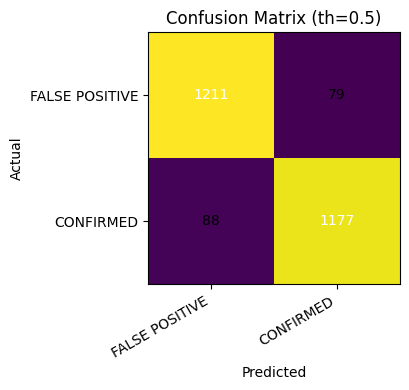

[INFO] saved → figs/confusion_matrix.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["FALSE POSITIVE", "CONFIRMED"]
cm_disp = cm  # from your code

fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm_disp, interpolation='nearest')
ax.set_title("Confusion Matrix (th=0.5)")
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=30, ha="right")
ax.set_yticklabels(labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 값 주석
thresh = cm_disp.max() / 2
for i in range(cm_disp.shape[0]):
    for j in range(cm_disp.shape[1]):
        ax.text(j, i, format(cm_disp[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_disp[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

import os
from google.colab import files

os.makedirs("figs", exist_ok=True)

def save_fig(fig, filename: str, download: bool = False, dpi: int = 200):
    path = os.path.join("figs", filename)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[INFO] saved → {path}")
    if download:
        files.download(path)

save_fig(fig, "confusion_matrix.png", download=True)
plt.show()



[INFO] saved → figs/roc_curve.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

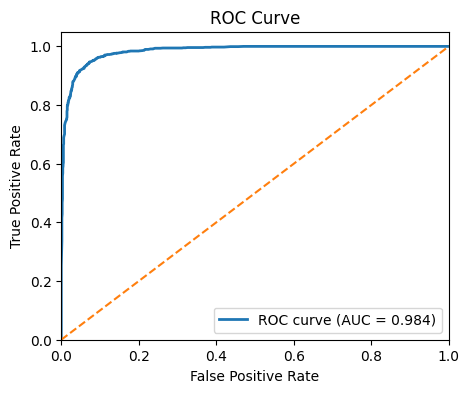

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thr = roc_curve(y_valid, valid_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(5,4)) # Get the figure object
ax.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
ax.plot([0,1],[0,1], linestyle="--")
ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend(loc="lower right")

save_fig(fig, "roc_curve.png", download=True) # Pass the figure object
plt.show()

[INFO] saved → figs/pr_curve.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

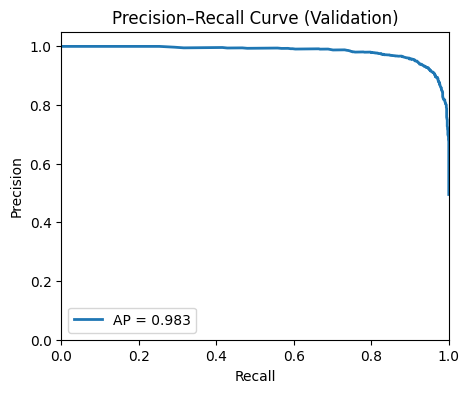

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

prec, rec, thr_pr = precision_recall_curve(y_valid, valid_proba)
ap = average_precision_score(y_valid, valid_proba)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.legend(loc="lower left")

save_fig("pr_curve.png", download=True)
plt.show()


[INFO] saved → figs/prob_hist.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

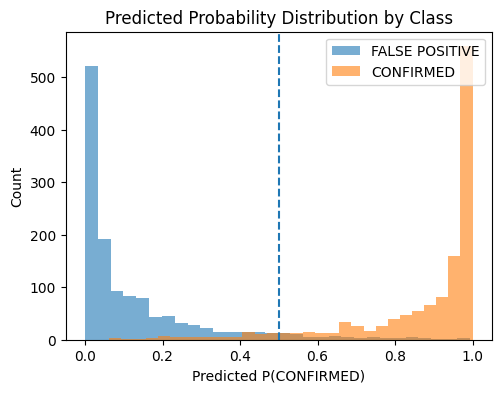

In [ ]:
import matplotlib.pyplot as plt
pos_mask = (y_valid == 1)
neg_mask = (y_valid == 0)

fig, ax = plt.subplots(figsize=(5.5,4)) # Get the figure object
ax.hist(valid_proba[neg_mask], bins=30, alpha=0.6, label="FALSE POSITIVE")
ax.hist(valid_proba[pos_mask], bins=30, alpha=0.6, label="CONFIRMED")
ax.axvline(0.5, linestyle="--")
ax.set_xlabel("Predicted P(CONFIRMED)")
ax.set_ylabel("Count")
ax.set_title("Predicted Probability Distribution by Class")
ax.legend()

save_fig(fig, "prob_hist.png", download=True) # Pass the figure object
plt.show()

[INFO] saved → figs/calibration_curve.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

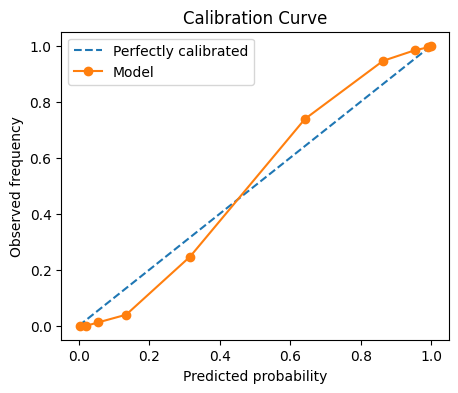

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_valid, valid_proba, n_bins=10, strategy='quantile')

fig, ax = plt.subplots(figsize=(5,4)) # Get the figure object
ax.plot([0,1],[0,1], linestyle="--", label="Perfectly calibrated")
ax.plot(prob_pred, prob_true, marker='o', label="Model")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Observed frequency")
ax.set_title("Calibration Curve")
ax.legend()

save_fig(fig, "calibration_curve.png", download=True) # Pass the figure object
plt.show()

In [ ]:
# 9) ====== CANDIDATE-only test 예측 ======
# out_path_pred = "candidate_only.csv"
out_path_pred = "only_candidate_test.csv"
out_path_metrics = "validation_metrics.txt"

if len(df_test) > 0:
    test_proba = pipe.predict_proba(X_test)[:, 1]
    test_pred = np.where(test_proba >= 0.5, "CONFIRMED", "FALSE POSITIVE")

    keep_id_cols = [c for c in ["rowid", "ra", "dec"] if c in df_test.columns]

    out = pd.DataFrame({
        "pred_confirmed_prob": test_proba,
        "pred_label": test_pred
    })
    for c in keep_id_cols:
        out[c] = df_test[c].values

    out.to_csv(out_path_pred, index=False)
    print(f"\n[INFO] Saved CANDIDATE predictions → {out_path_pred}")
    display(out.head(10))

    # # ★ 바로 다운로드
    # from google.colab import files
    # files.download(out_path_pred)

else:
    print("\n[INFO] CANDIDATE 행이 없어 test 예측은 건너뜁니다.")



[INFO] Saved CANDIDATE predictions → only_candidate_test.csv


,pred_confirmed_prob,pred_label,rowid,ra,dec
0,0.0875,FALSE POSITIVE,3,297.00482,48.134129
1,0.1575,FALSE POSITIVE,59,294.31686,50.080231
2,0.2625,FALSE POSITIVE,63,293.83331,50.230350
3,0.2500,FALSE POSITIVE,64,287.88733,46.276241
4,0.2350,FALSE POSITIVE,85,291.28195,38.241669
5,0.4350,FALSE POSITIVE,93,293.81619,38.563568
6,0.3275,FALSE POSITIVE,113,285.92001,39.624828
7,0.0350,FALSE POSITIVE,119,295.11371,40.071171
8,0.0225,FALSE POSITIVE,124,296.00699,40.295429
9,0.4150,FALSE POSITIVE,167,293.00797,42.307201


In [ ]:

# 10) ====== 검증 성능 요약 저장 ======
with open(out_path_metrics, "w") as f:
    f.write("Confusion Matrix:\n")
    f.write(str(cm) + "\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_valid, valid_pred, target_names=["FALSE POSITIVE", "CONFIRMED"]))
    f.write("\n")
    f.write(f"ROC-AUC: {auc}\n")

# print(f"[INFO] Saved validation metrics → {out_path_metrics}")

# (선택) Drive로 결과 복사하려면 주석 해제 후 경로 수정
# !cp candidate_predictions.csv "/content/drive/MyDrive/"
# !cp validation_metrics.txt "/content/drive/MyDrive/"


[INFO] Saved validation metrics → validation_metrics.txt


In [ ]:
# === 1) 모델 아티팩트 저장 ===
import joblib, sklearn, json

artifact = {
    "model": pipe,                 # SimpleImputer + RandomForest 파이프라인
    "features": X_cols,            # 학습에 사용된 컬럼 순서/목록
    "label_map": label_map,        # {"FALSE POSITIVE":0, "CONFIRMED":1}
    "sklearn_version": sklearn.__version__
}

model_path = "exoplanet_rf.joblib"
joblib.dump(artifact, model_path)
print(f"[INFO] Saved model → {model_path}")

# (선택) 메타데이터만 별도 JSON으로도 저장
with open("exoplanet_rf_meta.json", "w") as f:
    json.dump(
        {
            "features": X_cols,
            "label_map": label_map,
            "sklearn_version": sklearn.__version__
        },
        f, ensure_ascii=False, indent=2
    )
print("[INFO] Saved meta → exoplanet_rf_meta.json")

# === 2) 로컬로 다운로드(Colab) ===
from google.colab import files
files.download(model_path)
files.download("exoplanet_rf_meta.json")


[INFO] Saved model → exoplanet_rf.joblib
[INFO] Saved meta → exoplanet_rf_meta.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np

# 파이프라인의 imputer로 훈련/검증 데이터를 수치 행렬로 변환
imputer = pipe.named_steps["imputer"]
X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_cols, index=X_train.index)

# 피처별 상관계수 (y_train은 0/1)
corrs = X_train_imp.apply(lambda col: col.corr(y_train))
corr_df = pd.DataFrame({
    "feature": corrs.index,
    "pearson_corr": corrs.values,
    "abs_corr": np.abs(corrs.values),
}).sort_values("abs_corr", ascending=False)

print(corr_df.head(20))  # 상위 20개 미리보기

# 저장 + (Colab) 다운로드
# corr_df.to_csv("feature_correlation_pearson.csv", index=False)
# from google.colab import files
# files.download("feature_correlation_pearson.csv")


             feature  pearson_corr  abs_corr
46     koi_smet_err2      0.332476  0.332476
39    koi_steff_err1     -0.318602  0.318602
45     koi_smet_err1     -0.306473  0.306473
40    koi_steff_err2      0.278702  0.278702
51    koi_smass_err1     -0.263180  0.263180
59        pl_tranmid     -0.262332  0.262332
44          koi_smet      0.246312  0.246312
27          koi_incl      0.238054  0.238054
1                dec     -0.232805  0.232805
37  koi_num_transits     -0.226046  0.226046
43    koi_slogg_err2      0.218137  0.218137
28           koi_teq     -0.211855  0.211855
0                 ra     -0.199131  0.199131
58       pl_radjerr2      0.197064  0.197064
57       pl_radjerr1     -0.194918  0.194918
56           pl_radj     -0.194055  0.194055
83           st_logg      0.193637  0.193637
71           st_teff     -0.193400  0.193400
74            st_rad     -0.191522  0.191522
17         koi_depth     -0.190180  0.190180
